In [1]:
import palantir
import scanpy as sc
import pandas as pd
import os

# Plotting
import matplotlib
import matplotlib.pyplot as plt

# warnings
import warnings
from numba.core.errors import NumbaDeprecationWarning

warnings.filterwarnings(action="ignore", category=NumbaDeprecationWarning)
warnings.filterwarnings(
    action="ignore", module="scanpy", message="No data for colormapping"
)

# Inline plotting
%matplotlib inline

In [2]:
import anndata2ri
import logging
import rpy2.rinterface_lib.callbacks as rcb
import rpy2.robjects as ro

rcb.logger.setLevel(logging.ERROR)
ro.pandas2ri.activate()
anndata2ri.activate()

%load_ext rpy2.ipython

/tmp/ipykernel_16/2174054843.py:8: DeprecationWarning: The global conversion available with activate() is deprecated and will be removed in the next major release. Use a local converter.
  anndata2ri.activate()


In [3]:
%%R
data <- readRDS("mesoderm-development_loh (1).rds")
class(data)

[1] "dynwrap::with_cell_waypoints" "dynwrap::with_prior"         
[3] "dynwrap::with_expression"     "dynwrap::with_trajectory"    
[5] "dynwrap::with_grouping"       "dynwrap::data_wrapper"       
[7] "list"                        


In addition: Warning message:
In (function (package, help, pos = 2, lib.loc = NULL, character.only = FALSE,  :
  library ‘/usr/lib/R/site-library’ contains no packages


In [6]:
%%R
library(dynwrap)
# expression_matrix <- dynwrap::get_expression(data)
# write.csv(expression_matrix, 'mesoderm_expression_matrix.csv')
counts <- data$counts
write.csv(counts, 'mesoderm_counts_matrix.csv')

In [7]:
import scanpy as sc
import pandas as pd
import numpy as np

# expression_matrix = pd.read_csv("mesoderm_expression_matrix.csv", index_col=0)
counts = pd.read_csv("mesoderm_counts_matrix.csv", index_col=0)

# adata = sc.AnnData(expression_matrix)
adata = sc.AnnData(counts)

In [8]:
adata

AnnData object with n_obs × n_vars = 504 × 8772

In [9]:
ad = adata

In [11]:
ad.X = ad.X.astype(float)
sc.pp.normalize_per_cell(ad)
palantir.preprocess.log_transform(ad)
sc.pp.highly_variable_genes(ad, n_top_genes=1500, flavor="cell_ranger")

In [12]:
sc.pp.pca(ad)
ad

AnnData object with n_obs × n_vars = 504 × 8772
    obs: 'n_counts'
    var: 'highly_variable', 'means', 'dispersions', 'dispersions_norm'
    uns: 'hvg', 'pca'
    obsm: 'X_pca'
    varm: 'PCs'

In [13]:
dm_res = palantir.utils.run_diffusion_maps(ad, n_components=5)

In [14]:
ms_data = palantir.utils.determine_multiscale_space(ad)

In [15]:
sc.pp.neighbors(ad)
sc.tl.umap(ad)

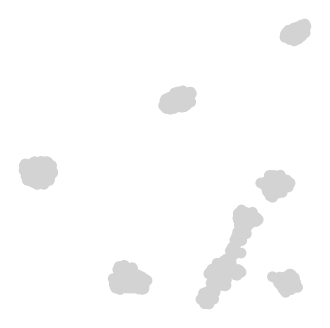

In [16]:
sc.pl.embedding(
    ad,
    basis="umap",
    frameon=False,
)

In [17]:
imputed_X = palantir.utils.run_magic_imputation(ad)

In [18]:
print(ad.var.head())
print(ad.var_names)

               highly_variable     means  dispersions  dispersions_norm
COL3A1                    True  5.100742     4.701964          8.721745
DKK4                      True  4.975039     4.393386          7.508408
CXCR4                     True  5.105981     4.546986          8.112367
RP11-513I15.6             True  5.363786     4.381274          9.724713
MIXL1                     True  7.656605     1.820409          4.184754
Index(['COL3A1', 'DKK4', 'CXCR4', 'RP11-513I15.6', 'MIXL1', 'ANXA1', 'NODAL',
       'DKK1', 'CER1', 'WNT3',
       ...
       'OPRL1', 'CTD-2003C8.2', 'RP4-814D15.1', 'RP11-366M4.6', 'LHX6',
       'NBEAP3', 'HLCS-IT1', 'RP11-44F14.5', 'AC073257.2', 'RP1-28C20.1'],
      dtype='object', length=8772)


In [19]:
genes_to_plot = ["T", "EOMES", "RUNX2"]

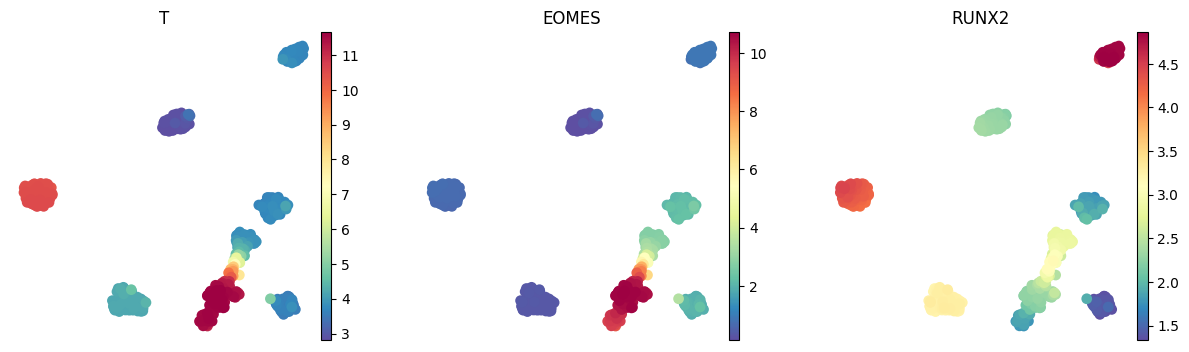

In [20]:
sc.pl.embedding(
    ad,
    basis="umap",
    layer="MAGIC_imputed_data",
    color=genes_to_plot,
    frameon=False,
)
plt.show()

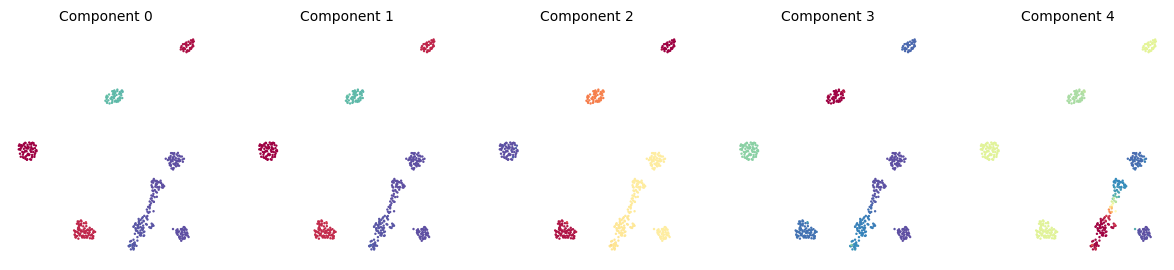

In [21]:
palantir.plot.plot_diffusion_components(ad)
plt.show()

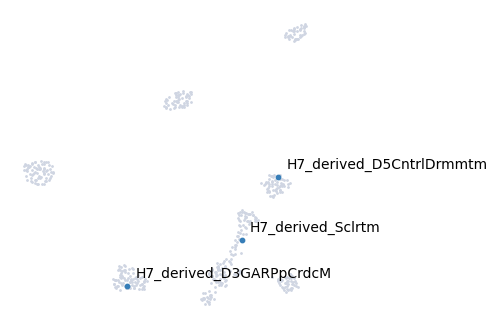

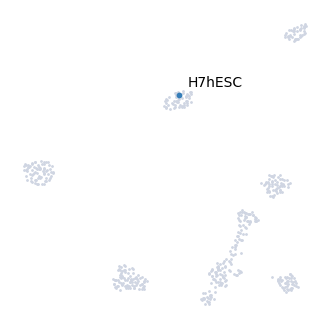

In [22]:
terminal_states = pd.Series(
    ["H7_derived_D5CntrlDrmmtm", "H7_derived_Sclrtm", "H7_derived_D3GARPpCrdcM"],
    index=["SRR3952713", "SRR3952690", "SRR3952891"],
)
start_cell = "SRR3952356"
start_states = pd.Series(['H7hESC'],index=['SRR3952356'])
palantir.plot.highlight_cells_on_umap(ad, terminal_states)
palantir.plot.highlight_cells_on_umap(ad, start_states)
plt.show()

In [23]:
%%R
str(data$prior)

List of 12
 $ start_milestones     : chr "H7hESC"
 $ start_id             : chr "SRR3952356"
 $ end_milestones       : chr [1:3] "H7_derived_D5CntrlDrmmtm" "H7_derived_Sclrtm" "H7_derived_D3GARPpCrdcM"
 $ end_id               : chr [1:3] "SRR3952713" "SRR3952690" "SRR3952891"
 $ groups_id            : tibble [504 × 2] (S3: tbl_df/tbl/data.frame)
  ..$ cell_id : chr [1:504] "SRR3952323" "SRR3952325" "SRR3952326" "SRR3952327" ...
  ..$ group_id: chr [1:504] "H7hESC" "H7hESC" "H7hESC" "H7hESC" ...
 $ groups_network       : tibble [9 × 2] (S3: tbl_df/tbl/data.frame)
  ..$ from: chr [1:9] "H7hESC" "H7hESC" "H7_derived_APS" "H7_derived_DLL1pPXM" ...
  ..$ to  : chr [1:9] "H7_derived_APS" "H7_derived_MPS" "H7_derived_DLL1pPXM" "H7_dreived_D2.25_Smtmrs" ...
 $ features_id          : chr [1:6195] "NODAL" "T" "TWIST1" "HAND1" ...
 $ groups_n             : int 9
 $ timecourse_continuous: Named num [1:504] 0 0 0 0 0 0 0 0 0 0 ...
  ..- attr(*, "names")= chr [1:504] "SRR3952323" "SRR3952325" "SRR39

In [24]:
pr_res = palantir.core.run_palantir(
    ad, start_cell, num_waypoints=500, terminal_states=terminal_states
)

Sampling and flocking waypoints...
Time for determining waypoints: 0.0009457945823669433 minutes
Determining pseudotime...
Shortest path distances using 30-nearest neighbor graph...


/opt/micromamba/envs/shortcake_default/lib/python3.10/site-packages/palantir/core.py:558: UserWarning: Some of the cells were unreachable. Consider increasing the k for 
             nearest neighbor graph construction.
  warnings.warn(


Time for shortest paths: 0.1912876764933268 minutes
Iteratively refining the pseudotime...
Correlation at iteration 1: 1.0000
Entropy and branch probabilities...
Markov chain construction...
Computing fundamental matrix and absorption probabilities...
Project results to all cells...


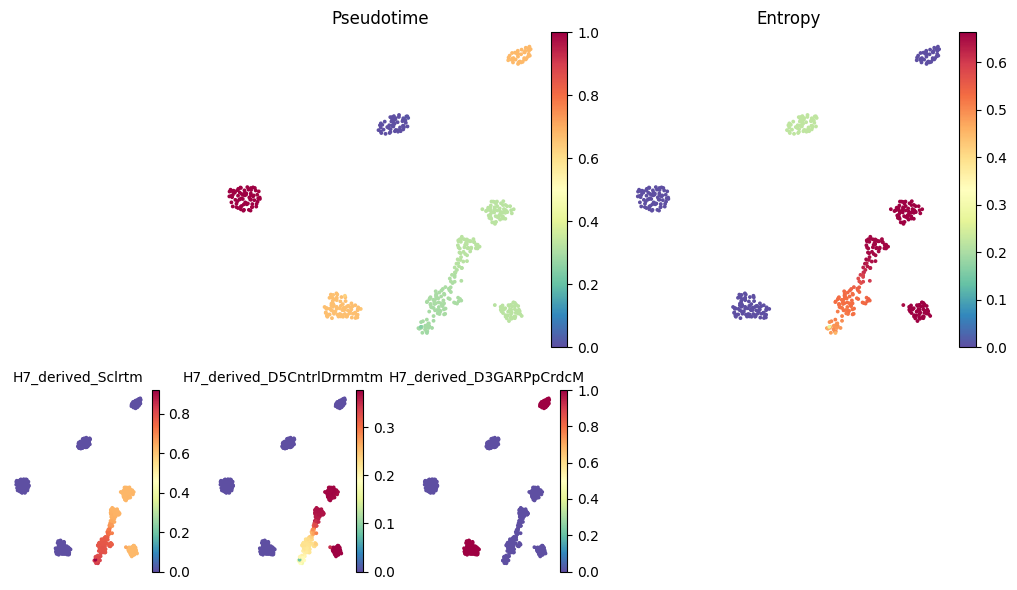

In [25]:
palantir.plot.plot_palantir_results(ad, s=3)
plt.show()

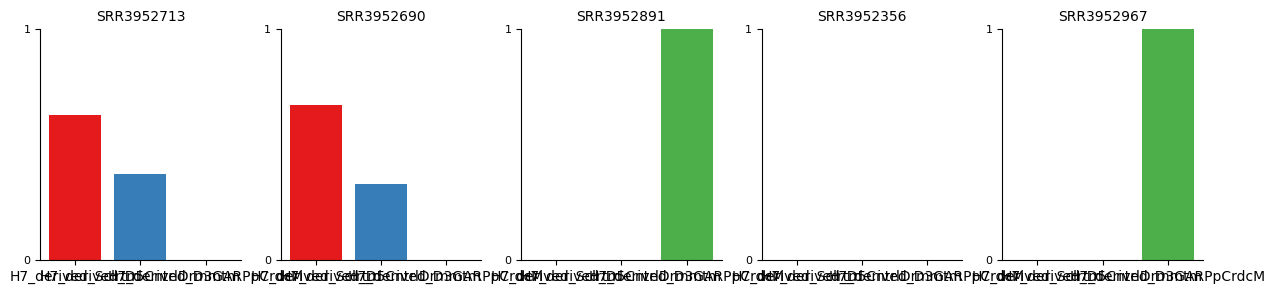

In [26]:
cells = [
    "SRR3952713", "SRR3952690", "SRR3952891", 'SRR3952356', 'SRR3952967'
]
palantir.plot.plot_terminal_state_probs(ad, cells)
plt.show()

In [27]:
masks = palantir.presults.select_branch_cells(ad, q=.01, eps=.01)

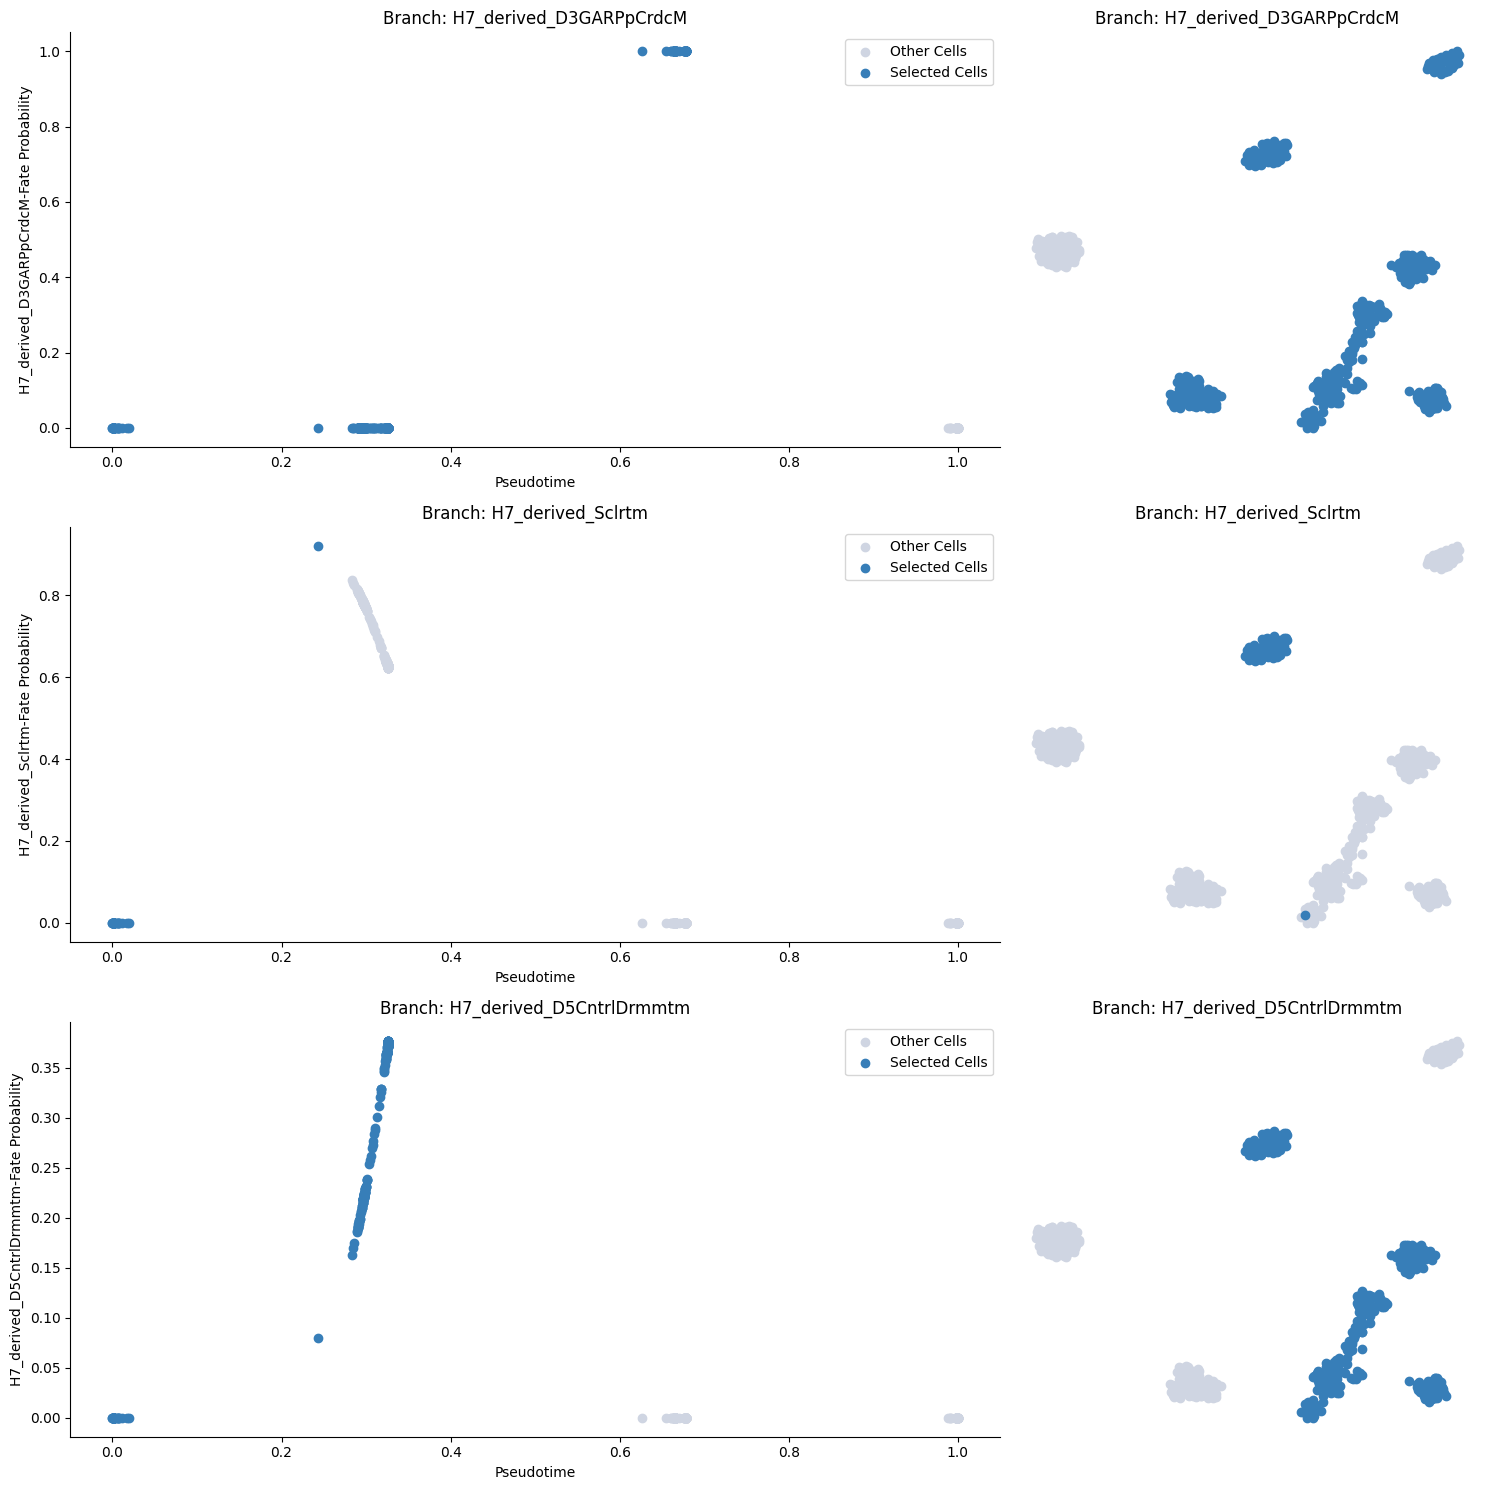

In [28]:
palantir.plot.plot_branch_selection(ad)
plt.show()

In [29]:
# H7_derived_D3GARPpCrdcM branch is probably wrong

[2025-01-24 07:55:28,290] [INFO    ] Using sparse Gaussian Process since n_landmarks (50) < n_samples (307) and rank = 1.0.
[2025-01-24 07:55:28,291] [INFO    ] Using covariance function Matern52(ls=1.744230079650879).
[2025-01-24 07:55:28,332] [INFO    ] Computing 50 landmarks with k-means clustering.
[2025-01-24 07:55:30,077] [INFO    ] Sigma interpreted as element-wise standard deviation.
[2025-01-24 07:55:30,568] [INFO    ] Using sparse Gaussian Process since n_landmarks (50) < n_samples (55) and rank = 1.0.
[2025-01-24 07:55:30,568] [INFO    ] Using covariance function Matern52(ls=1.744230079650879).
[2025-01-24 07:55:30,584] [INFO    ] Computing 50 landmarks with k-means clustering.
[2025-01-24 07:55:30,887] [INFO    ] Sigma interpreted as element-wise standard deviation.
[2025-01-24 07:55:30,995] [INFO    ] Using sparse Gaussian Process since n_landmarks (50) < n_samples (431) and rank = 1.0.
[2025-01-24 07:55:30,996] [INFO    ] Using covariance function Matern52(ls=1.7442300796

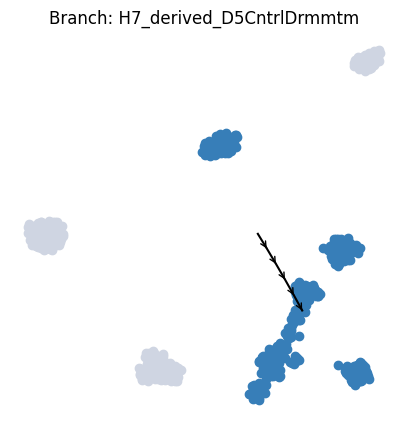

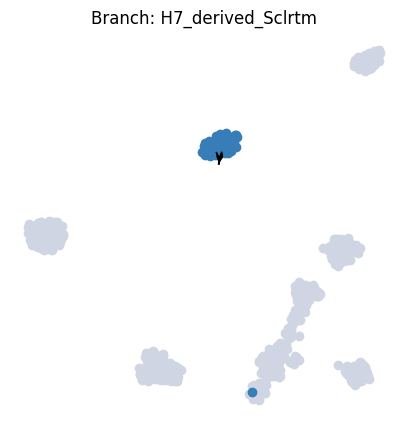

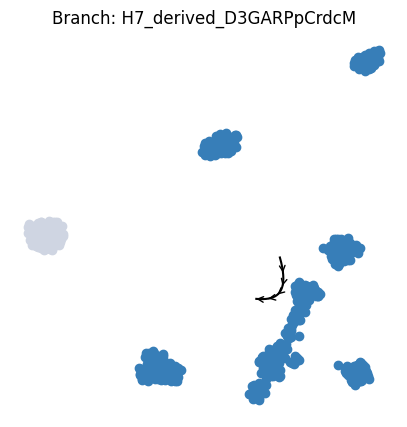

In [30]:
palantir.plot.plot_trajectory(ad, "H7_derived_D5CntrlDrmmtm")
palantir.plot.plot_trajectory(ad, "H7_derived_Sclrtm")
palantir.plot.plot_trajectory(ad, "H7_derived_D3GARPpCrdcM")
plt.show()

[2025-01-24 07:55:31,933] [INFO    ] Using sparse Gaussian Process since n_landmarks (50) < n_samples (55) and rank = 1.0.
[2025-01-24 07:55:31,934] [INFO    ] Using covariance function Matern52(ls=1.744230079650879).
[2025-01-24 07:55:31,935] [INFO    ] Computing 50 landmarks with k-means clustering.
[2025-01-24 07:55:31,950] [INFO    ] Sigma interpreted as element-wise standard deviation.


<Axes: title={'center': 'Branch: H7_derived_Sclrtm'}, xlabel='UMAP1', ylabel='UMAP2'>

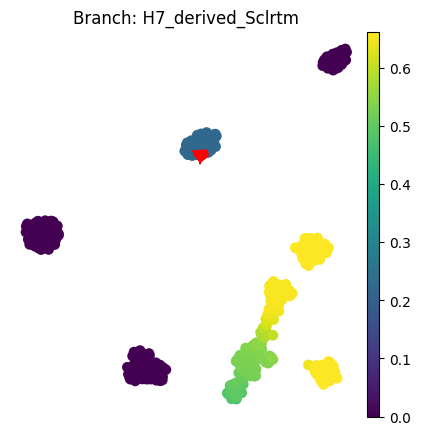

In [31]:
palantir.plot.plot_trajectory(
    ad,
    "H7_derived_Sclrtm",
    cell_color="palantir_entropy",
    n_arrows=10,
    color="red",
    scanpy_kwargs=dict(cmap="viridis"),
    arrowprops=dict(arrowstyle="-|>,head_length=.5,head_width=.5"),
)

In [32]:
gene_trends = palantir.presults.compute_gene_trends(
    ad,
    expression_key="MAGIC_imputed_data",
)

H7_derived_Sclrtm
[2025-01-24 07:55:35,385] [INFO    ] Using non-sparse Gaussian Process since n_landmarks (500) >= n_samples (55) and rank = 1.0.
[2025-01-24 07:55:35,387] [INFO    ] Using covariance function Matern52(ls=1.0).
[2025-01-24 07:55:36,376] [INFO    ] Sigma interpreted as element-wise standard deviation.
H7_derived_D5CntrlDrmmtm
[2025-01-24 07:55:37,024] [INFO    ] Using non-sparse Gaussian Process since n_landmarks (500) >= n_samples (307) and rank = 1.0.
[2025-01-24 07:55:37,025] [INFO    ] Using covariance function Matern52(ls=1.0).
[2025-01-24 07:55:37,600] [INFO    ] Sigma interpreted as element-wise standard deviation.
H7_derived_D3GARPpCrdcM
[2025-01-24 07:55:38,206] [INFO    ] Using non-sparse Gaussian Process since n_landmarks (500) >= n_samples (431) and rank = 1.0.
[2025-01-24 07:55:38,207] [INFO    ] Using covariance function Matern52(ls=1.0).
[2025-01-24 07:55:38,864] [INFO    ] Sigma interpreted as element-wise standard deviation.


In [33]:
ad.var_names

Index(['COL3A1', 'DKK4', 'CXCR4', 'RP11-513I15.6', 'MIXL1', 'ANXA1', 'NODAL',
       'DKK1', 'CER1', 'WNT3',
       ...
       'OPRL1', 'CTD-2003C8.2', 'RP4-814D15.1', 'RP11-366M4.6', 'LHX6',
       'NBEAP3', 'HLCS-IT1', 'RP11-44F14.5', 'AC073257.2', 'RP1-28C20.1'],
      dtype='object', length=8772)

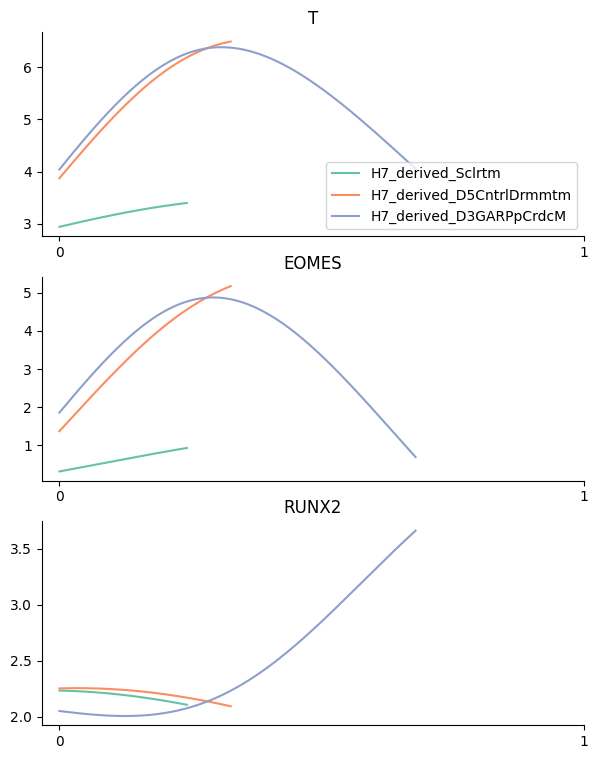

In [34]:
palantir.plot.plot_gene_trends(ad, genes_to_plot)
plt.show()

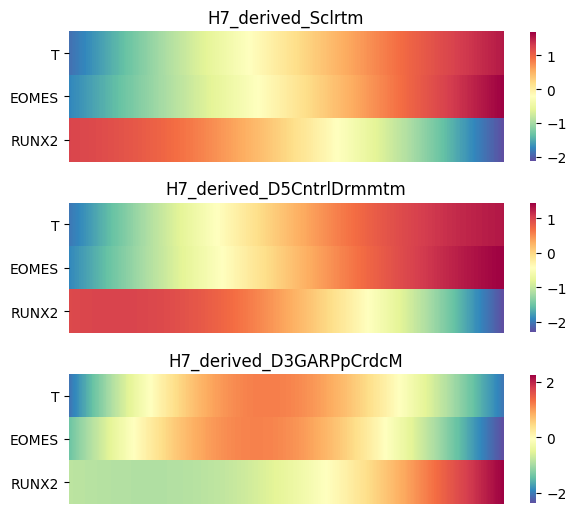

In [35]:
palantir.plot.plot_gene_trend_heatmaps(ad, genes_to_plot)
plt.show()

In [36]:
more_genes = ad.var_names[:1000]
communities = palantir.presults.cluster_gene_trends(ad, "H7_derived_Sclrtm", more_genes)

/opt/micromamba/envs/shortcake_default/lib/python3.10/site-packages/anndata/_core/anndata.py:401: FutureWarning: The dtype argument is deprecated and will be removed in late 2024.
  warnings.warn(
/opt/micromamba/envs/shortcake_default/lib/python3.10/site-packages/palantir/presults.py:481: FutureWarning: In the future, the default backend for leiden will be igraph instead of leidenalg.

 To achieve the future defaults please pass: flavor="igraph" and n_iterations=2.  directed must also be False to work with igraph's implementation.
  sc.tl.leiden(gt_ad, **kwargs)


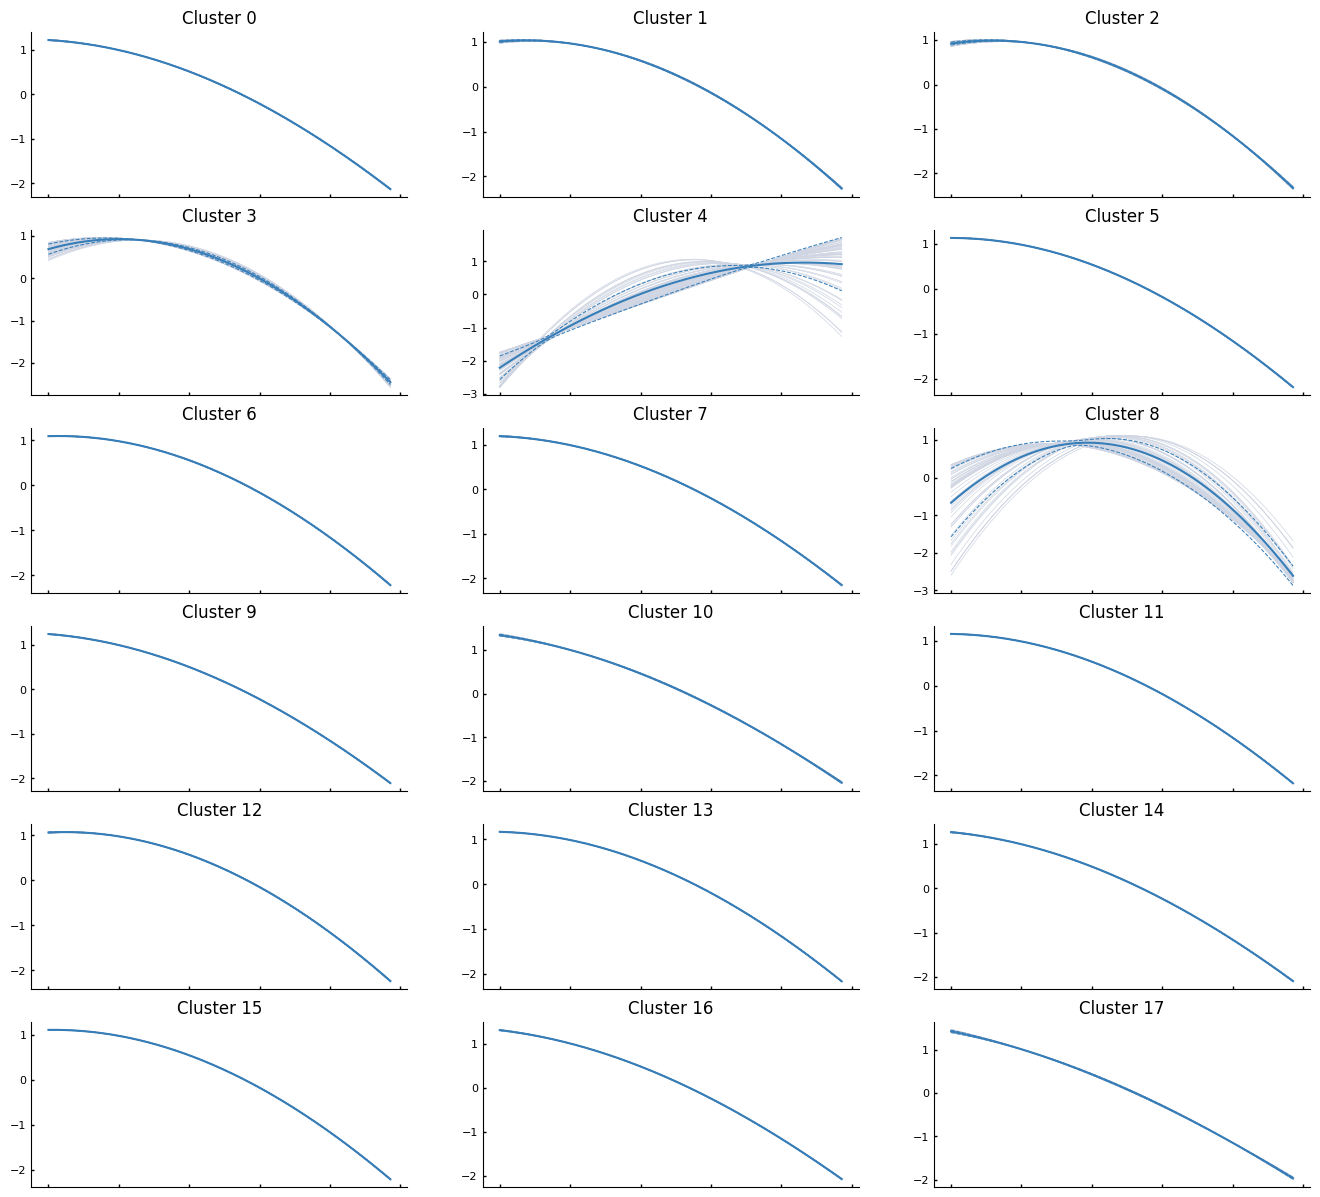

In [37]:
palantir.plot.plot_gene_trend_clusters(ad, "H7_derived_Sclrtm")
plt.show()